Informe LLM

En este informe, se justifica el uso de Falcon-7B para la creación de un chatbot limitado a cierta información.Específicamente se utilice la variante "Águila" disponible en Hugging Face. Águila es un modelo preentrenado por la Unidad de Tecnologías del Lenguaje del Barcelona Supercomputing Center, con un conjunto de datos primordialmente en español y catalán. Este chatbot se afina utilizando el modelo edumunozsala/aguila-7b-instructft-bactrian-x", el cual ha sido ajustado con el dataset Bactrian-X, optimizando la interacción en español.
Debido a las limitaciones de acceso a GPU's, el modelo se despliega utilizando técnicas de ajuste eficiente de parámetros y cuantización a 4 bits, asegurando así un uso eficiente de los recursos disponibles sin comprometer el rendimiento.


Instalacion de librerias

In [ ]:
pip install einops --progress-bar off

In [ ]:
pip install bitsandbytes --progress-bar off

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)


In [ ]:
pip install accelerate --progress-bar off

In [ ]:
pip install xformers --progress-bar off

In [ ]:
pip install langchain

In [ ]:
!pip install langchain_community --progress-bar off

In [ ]:
import re
import warnings
from typing import List

import torch
from langchain import PromptTemplate
from langchain.chains import ConversationChain
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.llms import HuggingFacePipeline
from langchain.schema import BaseOutputParser
from transformers import (
                            AutoModelForCausalLM,
                            AutoTokenizer,
                            StoppingCriteria,
                            StoppingCriteriaList,
                            pipeline,)

Instalacion del modelo a implementado

In [ ]:
# The model was fine tuned in the spanish split of the Bactrain-X dataset.

## This model was fine tuned by:
"""
@misc {edumunozsala_2023,
    author       = { {Eduardo Muñoz} },
    title        = { aguila-7b-instructft-bactrian-x },
    year         = 2024,
    url          = { https://huggingface.co/edumunozsala/aguila-7b-instructft-bactrian-x },
    publisher    = { Hugging Face }
}
"""

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Especificar el nombre del modelo de Hugging Face.
model_name = "projecte-aina/aguila-7b"

# Configurar la cuantización para 8 bits.
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

# Crear un mapa de dispositivos personalizado.
device_map = {
    "transformer.h": "auto",
    "lm_head": "cpu"  # Mueve la cabeza del modelo a la CPU
}

# Cargar el modelo directamente de Hugging Face.
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    quantization_config=quantization_config,
    device_map="auto"
)

# Reducir el uso de memoria colocando el modelo en modo de evaluación.
model.eval()

# Cargar el tokenizer directamente de Hugging Face.
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_RW.py:   0%|          | 0.00/2.61k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/projecte-aina/aguila-7b:
- configuration_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modelling_RW.py:   0%|          | 0.00/47.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/projecte-aina/aguila-7b:
- modelling_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/165M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/844k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/503k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

In [ ]:
generation_config = model.generation_config

generation_config.do_sample = True # Desactivar el muestreo para una generación determinista
generation_config.temperature = 0.90 # Establecer la temperatura a 1.0 para una generación determinista
generation_config.num_return_sequences = 1  # Generar solo una secuencia
generation_config.max_length = 1500  # Longitud máxima de la secuencia generada
generation_config.repetition_penalty = 1.0  # Ajustar según sea necesario
generation_config.pad_token_id = tokenizer.eos_token_id  # Identificador del token de padding
generation_config.eos_token_id = tokenizer.eos_token_id  # Identificador del token de fin de secuencia
generation_config.max_new_tokens = 256

Ver la configuración del modelo.

In [ ]:
model.config

RWConfig {
  "_name_or_path": "projecte-aina/aguila-7b",
  "alibi": false,
  "apply_residual_connection_post_layernorm": false,
  "architectures": [
    "RWForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "projecte-aina/aguila-7b--configuration_RW.RWConfig",
    "AutoModel": "projecte-aina/aguila-7b--modelling_RW.RWModel",
    "AutoModelForCausalLM": "projecte-aina/aguila-7b--modelling_RW.RWForCausalLM",
    "AutoModelForQuestionAnswering": "projecte-aina/aguila-7b--modelling_RW.RWForQuestionAnswering",
    "AutoModelForSequenceClassification": "projecte-aina/aguila-7b--modelling_RW.RWForSequenceClassification",
    "AutoModelForTokenClassification": "projecte-aina/aguila-7b--modelling_RW.RWForTokenClassification"
  },
  "bias": false,
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "hidden_dropout": 0.0,
  "hidden_size": 4544,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "RefinedWebMod

Inicializar el prompt del modelo.

In [ ]:
# Este modelo está afinado para entender las instrucciones:
instruccion = "Responda correctamente"

# Que es lo que queremos preguntar:
input_text = "¿La manzana es una fruta o verdura?"

# Los modelos Falcon no están entrenados con un prompt específico
prompt = f"""### Instrucción:
{instruccion}

### Entrada:
{input_text}

### Respuesta:
""".strip()

input_ids = tokenizer(prompt, return_tensors = "pt").input_ids

input_ids = input_ids.to(model.device)

Generar conversación:

In [ ]:
%%time
with torch.inference_mode():
    outputs = model.generate(
        input_ids = input_ids,
        generation_config = generation_config,
        )

CPU times: user 49.5 s, sys: 250 ms, total: 49.7 s
Wall time: 51.1 s


Decodificar la respuesta

In [ ]:
response = tokenizer.decode(outputs[0], skip_special_yokens=True)

print(response)

### Instrucción:
Responda correctamente

### Entrada:
¿La manzana es una fruta o verdura?

### Respuesta:

### VERDADERO / FALSO

###Puntuación: 0-0,5 puntos por respuesta acertada.

###Puntuación: 0-0,1 puntos por respuesta incorrecta.

###Máximo: 1 punto.

###Ejemplo:

Supongamos que el sistema es 100% correcto (0-0,5), y que su puntuación máxima es 0,1.

En este caso la respuesta correcta es la B.

###Puntuación total: 2 puntos.

###Total: 2 puntos.

</table>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br>

<br


#Evitar la divagación del modelo
A veces, el modelo puede comenzar a divagar. Aunque este problema aún se está investigando en el contexto de este tipo de modelos, existen pequeños "parches" que se pueden implementar para mitigarlo.







In [ ]:
# Clase para detener la generación de tokens.
class StopGenerationCriteria(StoppingCriteria):
    # Inicializador de la clase.
    def __init__(
                self, tokens: List[List[str]], tokenizer: AutoTokenizer, device: torch.device
    ):
        # Convertir las palabras stop a tokens
        stop_tokens_ids = [tokenizer.convert_tokens_to_ids(token) for token in tokens]
        # Guardar los stop tokens en un tensor.
        self.stop_token_ids =[
            torch.tensor(x, dtype=torch.long, device=device) for x in stop_tokens_ids
        ]

    def __call__(
            self, input_ids: torch.LongTensor, scores:torch.FloatTensor, **kwargs
    ) -> bool:
        # Revisar si se encuentra el stop token en la generación del texto.
        for stop_ids in self.stop_token_ids:
            if torch.eq(input_ids[0][-len(stop_ids) :], stop_ids).all():
                return True
        return False

#Selección de palabras especiales para detener la generación de tokens
Se seleccionarán palabras especiales que detendrán la generación de tokens. En nuestro caso, esto ocurrirá cuando la IA intente generar otra línea de diálogo del "Human".







In [ ]:
# Tokens para detener la generación de texto.
stop_tokens = [["#", "#"], ["AI", ":"]]

# Crear la clase de "stop token".
stopping_criteria = StoppingCriteriaList(
    [StopGenerationCriteria(stop_tokens, tokenizer, model.device)]
)

In [ ]:
generation_pipeline = pipeline(
    model = model,
    tokenizer = tokenizer,
    return_full_text=True,
    task="text-generation",
    stopping_criteria=stopping_criteria,
    generation_config=generation_config,
)

llm = HuggingFacePipeline(pipeline=generation_pipeline)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(


In [ ]:
res = llm(prompt)
print(res)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


### Instrucción:
Responda correctamente

### Entrada:
¿La manzana es una fruta o verdura?

### Respuesta:

##


#Chain
Hacer que el modelo mantenga una conversación con el usuario (Recordar los últimos inputs).

In [ ]:
# Inicializamos la cadena.
chain = ConversationChain(llm=llm)

# Vemos la plantilla (predeterminada) de la conversación:
print(chain.prompt.template)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:


In [ ]:
# Como nuestro modelo esta en español debemos de cambiar la plantilla a una más adecuada
template = """### Instrucción:
Responde correctamente

### Conversación actual:
{history}

### Entrada:
{input}

### Respuesta:
""".strip()

# Ajustamos la nueva plantilla.
prompt = PromptTemplate(input_variables=["history", "input"], template=template)

print(template)

### Instrucción:
Responde correctamente

### Conversación actual:
{history}

### Entrada:
{input}

### Respuesta:


Permitir que el modelo recuerde la conversación

In [ ]:
# Nueva input
text = "¿De que color es la manzana?".strip()

# Creamos el historial para el modelo.
# (Solo recordar las respuestas del modelo)
memory = ConversationBufferWindowMemory(
    memory_key="history",  # Especifica la clave para los datos de historial
    k=4,
    return_only_outputs=True
)


In [ ]:
# Respuesta:
res = chain.predict(input = text)

In [ ]:
print(res)

The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: ¿De que color es la manzana?
AI: ¿La manzana es verde?
Human: ¿De que color?
Human: Verde
AI:


#Eliminar ciertos patrones que aparecen en la respuesta

En este caso, el modelo no genera respuestas no deseadas. Sin embargo, es importante estar preparado para eliminar ciertos patrones que puedan aparecer en las respuestas. A continuación, se presenta la clase que se utilizaría si fuera necesario.

In [ ]:
class CleanupOutputParser(BaseOutputParser):
    # Definir el patron que se necesita limpiar (Esto lo dictará el uso del modelo.)
    def parse(self, text: str) -> str:
        # Seleccionar el elemento que desamos eliminar de la generación de texto.
        usser_pattern = r"\nUser"
        text = re.sub(usser_pattern, "", text)
        cat_pattern = r"\n##"
        return re.sub(cat_pattern, "", text)

    @property
    def _type(self) -> str:
        return "output_parser"

In [ ]:
# Ajustamos las nuevas configuraciones:
memory = ConversationBufferWindowMemory(
    memory_key="history",  # Especifica la clave para los datos de historial
    k=3,
    return_only_outputs=True
)

# Actualizamos nuestra cadena con las nuevas configuraciones.
chain = ConversationChain(llm=llm, memory=memory, prompt=prompt, output_parser=CleanupOutputParser(), verbose=True)

# Primeras pruebas

In [ ]:
# Mantenemos la conversación
text = "¿De qué color es la manzana?".strip()

# Nueva respuesta:
res = chain(text)



> Entering new ConversationChain chain...
Prompt after formatting:
### Instrucción:
Responde correctamente

### Conversación actual:


### Entrada:
¿De qué color es la manzana?

### Respuesta:


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(



> Finished chain.


In [ ]:
res.keys()

dict_keys(['input', 'history', 'response'])

In [ ]:
print(res)

{'input': '¿De qué color es la manzana?', 'history': '', 'response': '### Instrucción:\nResponde correctamente\n# Conversación actual:\n\n# Entrada:\n¿De qué color es la manzana?\n# Respuesta: Verdadero\n'}


In [ ]:
print(res['response'])

### Instrucción:
Responde correctamente
# Conversación actual:

# Entrada:
¿De qué color es la manzana?
# Respuesta: Verdadero



In [ ]:
text = "¿Solo existen manzanas rojas?".strip()

res = chain(text)



> Entering new ConversationChain chain...
Prompt after formatting:
### Instrucción:
Responde correctamente

### Conversación actual:
Human: ¿De qué color es la manzana?
AI: ### Instrucción:
Responde correctamente
# Conversación actual:

# Entrada:
¿De qué color es la manzana?
# Respuesta: Verdadero


### Entrada:
¿Solo existen manzanas rojas?

### Respuesta:

> Finished chain.


In [ ]:
print(res['response'])

### Instrucción:
Responde correctamente
# Conversación actual:
Human: ¿De qué color es la manzana?
AI: ### Instrucción:
Responde correctamente
# Conversación actual:

# Entrada:
¿De qué color es la manzana?
# Respuesta: Verdadero

# Entrada:
¿Solo existen manzanas rojas?
# Respuesta: Verdadero




#Proporcionar contexto al modelo
La idea general de esta sección se detalla en la documentación de este trabajo . Sin embargo, se realizará una breve revisión del concepto general. La necesidad principal es proporcionar al modelo un contexto adecuado (en este caso noticias en Español) para que pueda responder preguntas relacionadas con ellos. Esta problemática se resuelve mediante Langchain y su variedad de librerías.

Langchain aborda esta situación utilizando una técnica de word embedding y modificando el prompt del modelo. Toma la consulta del usuario y busca en el contexto general partes del texto que se asemejan a la consulta, obteniendo párrafos que se incluyen en el prompt como contexto. De esta manera, el modelo mantiene su eficacia y obtiene un contexto adecuado.

Las principales problemáticas que se presentan son las siguientes:

El prompt no es muy eficaz.
El word embedding no se adecua a las necesidades específicas.

Dado que estos elementos están interrelacionados, la precisión del modelo puede disminuir si alguno de ellos no está afinado adecuadamente. Esto se debe a que, al no tener modelos optimizados para cada tarea, se añade "ruido" al sistema. Lo más adecuado sería ajustar los modelos según las necesidades específicas de cada tarea. Sin embargo, por limitaciones de datos y tiempo, no se realizará este ajuste por ahora.

Por ejemplo, si las noticias contienen tablas, afinar un modelo OCR que pueda extraer esta información de manera adecuada mejoraría la precisión del modelo.

Librerías necesarias para esta parte:
LangChain
Algún OCR
InstructorEmbedding
sentence_transformers

In [ ]:
pip install InstructorEmbedding

In [ ]:
pip install sentence-transformers==2.2.2 # Conjunto de elementos que nuestro embedding necesita

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=13fab82746661b7e8d7904a84ecb64f02a0fe6f285b9080b7b52720e5c3c8b7f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.9 MB/s eta 0:00:00


In [ ]:
from langchain.chains import LLMChain, ConversationalRetrievalChain # Chat con memoria y que obtiene info.
from langchain.embeddings import HuggingFaceInstructEmbeddings, HuggingFaceEmbeddings # Uso del WordEmbedding.
from langchain.text_splitter import RecursiveCharacterTextSplitter # Separar el texto.
from langchain.vectorstores import FAISS # Crear una mini-base de datos.
from langchain.memory import ConversationBufferMemory

#Carga del dataset de noticias en Español

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df= pd.read_excel('/content/drive/MyDrive/Colab Notebooks/df_noticias.xlsx')


In [ ]:
df.head()

,ArticleId,Texto,Categoría
0,1833,worldcom ex-jefe de lanza de la defensa de los...,negocio
1,154,alemán de confianza empresarial diapositivas a...,negocio
2,1101,bbc encuesta indica pesimismo económico de los...,negocio
3,1976,estilo de vida que rige la elección de disposi...,tecnologia
4,917,enron jefes en fue de $168 millones de pago de...,negocio


In [ ]:
df.shape

(1580, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580 entries, 0 to 1579
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1580 non-null   int64 
 1   Texto      1580 non-null   object
 2   Categoría  1580 non-null   object
dtypes: int64(1), object(2)
memory usage: 37.2+ KB


In [ ]:
df['Categoría'].value_counts()

Categoría
deporte            363
negocio            353
política           295
entretenimiento    294
tecnologia         275
Name: count, dtype: int64

In [ ]:
target_category = df['Categoría'].unique()
print(target_category)

['negocio' 'tecnologia' 'política' 'deporte' 'entretenimiento']


In [ ]:
df['CategoryId'] = df['Categoría'].factorize()[0]
df.head(12)

,ArticleId,Texto,Categoría,CategoryId
0,1833,worldcom ex-jefe de lanza de la defensa de los...,negocio,0
1,154,alemán de confianza empresarial diapositivas a...,negocio,0
2,1101,bbc encuesta indica pesimismo económico de los...,negocio,0
3,1976,estilo de vida que rige la elección de disposi...,tecnologia,1
4,917,enron jefes en fue de $168 millones de pago de...,negocio,0
5,1582,howard truanted jugar al billar líder conserva...,política,2
6,651,gales silencio en el grand slam de hablar rhys...,deporte,3
7,1797,francés honor para el director parker director...,entretenimiento,4
8,2034,el gigante del automóvil golpeado por mercedes...,negocio,0
9,1866,fockers de combustible festiva de cine gráfico...,entretenimiento,4


In [ ]:
category = df[['Categoría', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Categoría,CategoryId
0,negocio,0
3,tecnologia,1
5,política,2
6,deporte,3
7,entretenimiento,4


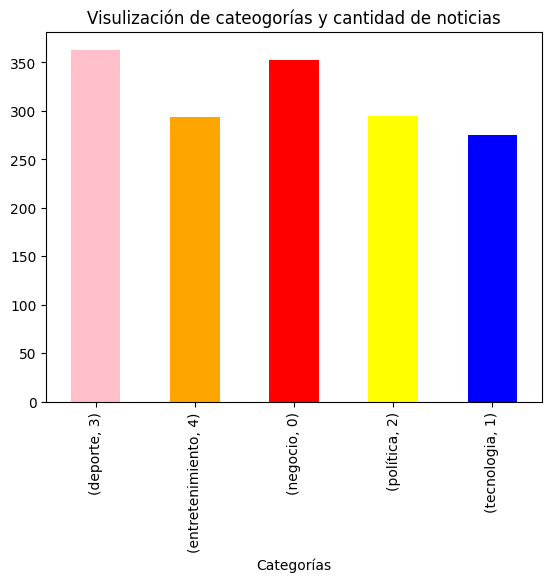

In [ ]:
import matplotlib.pyplot as plt
df.groupby('Categoría').CategoryId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Categorías")
plt.title("Visulización de cateogorías y cantidad de noticias")
plt.show()

#Elegimos una noticia al azar del dataset para extraer directamente el contexto

In [ ]:
# Seleccionar una fila al azar
random_row = df.sample(n=1)

# Extraer el texto de la columna 'texto' de la fila seleccionada
text_extracted = random_row['Texto'].iloc[0]

# Mostrar el texto extraído
print(text_extracted)

la preocupación por las etiquetas rfid de los consumidores están preocupados por el uso de radio frecuencia de identificación (rfid) de las etiquetas en las tiendas una encuesta dice. más de la mitad de 2 000 personas encuestadas dijeron que habían de privacidad preocupaciones acerca de las etiquetas que pueden ser utilizadas para monitorear existencias en los estantes o en los almacenes. algunos grupos de consumidores han expresado su preocupación de que las etiquetas podrían ser utilizados para supervisar a los compradores una vez que habían dejado las tiendas con sus compras. la encuesta mostró que el conocimiento de etiquetas entre los consumidores en europa fue baja. la encuesta de los consumidores en el reino unido, francia, alemania y los países bajos se llevó a cabo por el grupo de consultoría capgemini. la firma trabaja en nombre de más de 30 empresas que están tratando de promover el crecimiento de la tecnología rfid. las etiquetas son una combinación de equipo chip y la ante

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=512,
                chunk_overlap=51)

text_splitted = text_splitter.split_text(text_extracted)

#Crear los embeddings
Cualquier tipo de embedding sería útil para esta tarea. En este caso se utiliza el embedding: https://huggingface.co/intfloat/multilingual-e5-large-instruct/tree/main que mostró buenos resultados en text similarity



In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name='sentence-transformers/LaBSE'
)


In [ ]:
vectorstore = FAISS.from_texts(texts=text_splitted, embedding = embeddings)

In [ ]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

#Crear otra cadena que ahora tome los nuevos embeddings

In [ ]:
# Modificar la plantilla para que se pueda añadir contexto.
template = """### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
{context}


### Pregunta:
{question}.

### Respuesta:
""".strip()

# Es importante saber que las palabras "context", "chat_history" y "question" son necesarias para ConversationalRetrievalChain

# Ajustamos la nueva plantilla.
prompt = PromptTemplate(input_variables=["context", "chat_history", "question"], template=template)

In [ ]:
memory = ConversationBufferMemory(
    memory_key="chat_history",  # Especifica la clave para los datos de historial
    return_messages=True,
    input_key="question"
)

In [ ]:
question_generator_chain = LLMChain(llm=llm, prompt=prompt)

retrival_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    return_source_documents=False,
    verbose = True,
    combine_docs_chain_kwargs={'prompt': prompt},
    memory = memory,
    rephrase_question=False,
)

#Pruebas
Realizar algunas preguntas adicionales para ver como es que el modelo se comporta

In [ ]:
text = "¿Cuáles son las principales preocupaciones de los consumidores respecto al uso de etiquetas RFID en las tiendas?".strip()

res = retrival_chain({"question":text})



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
la preocupación por las etiquetas rfid de los consumidores están preocupados por el uso de radio frecuencia de identificación (rfid) de las etiquetas en las tiendas una encuesta dice. más de la mitad de 2 000 personas encuestadas dijeron que habían de privacidad preocupaciones acerca de las etiquetas que pueden ser utilizadas para monitorear existencias en los estantes o en los almacenes. algunos grupos de consumidores han expresado su preocupación de que las etiquetas podrían ser utilizados para supervisar

tecnología rfid. las etiquetas son una combinación de equipo chip y la antena que puede ser leído por un escáner de cada elemento contiene un número de identificación único. más de la mitad (55%) de los encuestados dijeron que estaban p

In [ ]:
print(res)

{'question': '¿Cuáles son las principales preocupaciones de los consumidores respecto al uso de etiquetas RFID en las tiendas?', 'chat_history': [HumanMessage(content='¿Cuáles son las principales preocupaciones de los consumidores respecto al uso de etiquetas RFID en las tiendas?'), AIMessage(content='### Instrucción:\nEres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.\n\n### Contexto:\nla preocupación por las etiquetas rfid de los consumidores están preocupados por el uso de radio frecuencia de identificación (rfid) de las etiquetas en las tiendas una encuesta dice.\xa0más de la mitad de 2 000 personas encuestadas dijeron que habían de privacidad preocupaciones acerca de las etiquetas que pueden ser utilizadas para monitorear existencias en los estantes o en los almacenes.\xa0algunos grupos de consumidores han expresado su preocupación de que las etiquetas podrían ser utilizados para supervisar\n\ntecnología rfid.\xa0las eti

In [ ]:
print(res['answer'])

### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
la preocupación por las etiquetas rfid de los consumidores están preocupados por el uso de radio frecuencia de identificación (rfid) de las etiquetas en las tiendas una encuesta dice. más de la mitad de 2 000 personas encuestadas dijeron que habían de privacidad preocupaciones acerca de las etiquetas que pueden ser utilizadas para monitorear existencias en los estantes o en los almacenes. algunos grupos de consumidores han expresado su preocupación de que las etiquetas podrían ser utilizados para supervisar

tecnología rfid. las etiquetas son una combinación de equipo chip y la antena que puede ser leído por un escáner de cada elemento contiene un número de identificación único. más de la mitad (55%) de los encuestados dijeron que estaban preocupados o muy preocupados de que las etiquetas rfid permitiría a las empresas para el seguimiento de lo

In [ ]:
# Nueva query
text = "¿Qué porcentaje de los encuestados expresaron preocupación por la posibilidad de que las etiquetas RFID permitan el seguimiento de los consumidores?".strip()

res = retrival_chain({r"question":text})



> Entering new LLMChain chain...
Prompt after formatting:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:

Human: ¿Cuáles son las principales preocupaciones de los consumidores respecto al uso de etiquetas RFID en las tiendas?
Assistant: ### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
la preocupación por las etiquetas rfid de los consumidores están preocupados por el uso de radio frecuencia de identificación (rfid) de las etiquetas en las tiendas una encuesta dice. más de la mitad de 2 000 personas encuestadas dijeron que habían de privacidad preocupaciones acerca de las etiquetas que pueden ser utilizadas para monitorear existencias en los estantes o en los almacenes. algunos grupos de consumidores han expresado su preocupación de que las etiquetas podrían ser utilizados para s

In [ ]:
print(res['answer'])

### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
tecnología rfid. las etiquetas son una combinación de equipo chip y la antena que puede ser leído por un escáner de cada elemento contiene un número de identificación único. más de la mitad (55%) de los encuestados dijeron que estaban preocupados o muy preocupados de que las etiquetas rfid permitiría a las empresas para el seguimiento de los consumidores a través de la compra de productos. cincuenta y nueve por ciento de las personas dijeron que estaban preocupados de que las etiquetas rfid permitiría ser

la preocupación por las etiquetas rfid de los consumidores están preocupados por el uso de radio frecuencia de identificación (rfid) de las etiquetas en las tiendas una encuesta dice. más de la mitad de 2 000 personas encuestadas dijeron que habían de privacidad preocupaciones acerca de las etiquetas que pueden ser utilizadas para monitorear 

In [ ]:
# Nueva query
text = "¿Qué áreas de aplicación se mencionan en la noticia donde las etiquetas RFID están actualmente en uso?".strip()

res = retrival_chain({r"question":text})



> Entering new LLMChain chain...
Prompt after formatting:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:

Human: ¿Cuáles son las principales preocupaciones de los consumidores respecto al uso de etiquetas RFID en las tiendas?
Assistant: ### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
la preocupación por las etiquetas rfid de los consumidores están preocupados por el uso de radio frecuencia de identificación (rfid) de las etiquetas en las tiendas una encuesta dice. más de la mitad de 2 000 personas encuestadas dijeron que habían de privacidad preocupaciones acerca de las etiquetas que pueden ser utilizadas para monitorear existencias en los estantes o en los almacenes. algunos grupos de consumidores han expresado su preocupación de que las etiquetas podrían ser utilizados para s

In [ ]:
print(res['answer'])

### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
tecnología rfid. las etiquetas son una combinación de equipo chip y la antena que puede ser leído por un escáner de cada elemento contiene un número de identificación único. más de la mitad (55%) de los encuestados dijeron que estaban preocupados o muy preocupados de que las etiquetas rfid permitiría a las empresas para el seguimiento de los consumidores a través de la compra de productos. cincuenta y nueve por ciento de las personas dijeron que estaban preocupados de que las etiquetas rfid permitiría ser

la preocupación por las etiquetas rfid de los consumidores están preocupados por el uso de radio frecuencia de identificación (rfid) de las etiquetas en las tiendas una encuesta dice. más de la mitad de 2 000 personas encuestadas dijeron que habían de privacidad preocupaciones acerca de las etiquetas que pueden ser utilizadas para monitorear 

#Las noticias del dataset son breves y con mala traduccion, utilizare una noticia mas extensa en español para realizar mas pruebas

In [ ]:
#Nueva prueba:
text_extracted = """
El James Webb bate un nuevo récord al observar la galaxia más lejana, formada tan sólo 290 millones de años después del Big Bang
Según asegura la Agencia Espacial Europea (ESA) en un comunicado, gracias al telescopio espacial más potente se ha encontrado la galaxia más antigua observada hasta ahora.
El telescopio espacial James Webb ha observado una galaxia que se originó tan sólo 290 millones de años después del Big Bang, batiendo el récord logrado hasta ahora a la hora de buscar las primeras galaxias que se formaron en el universo. La nueva galaxia, la más antigua por tanto descubierta, ha sido denominada JADES-GS-z14-0.

El anuncio ha sido realizado por la Agencia Espacial Europea (ESA), que opera el telescopio junto a la NASA y a la agencia espacial canadiense, en un comunicado. El descubrimiento todavía no ha sido publicado en una revista científica.

Durante los últimos dos años, los científicos han usado el James Webb, el telescopio espacial más potente lanzado hasta ahora, para rastrear las primeras etapas de formación del universo, cuando se formaron las primeras galaxias. Estudiar este periodo les permite obtener información sobre cómo se comportaba el gas, las estrellas y los agujeros negros cuando el universo era un recién nacido.

En octubre de 2023 y enero de 2024, un equipo internacional de astrónomos realizó una campaña de observaciones como parte del programa JWST Advanced Deep Extragalactic Survey (JADES). Utilizando uno de sus instrumentos, el espectrógrafo en infrarrojo NIRSpec, pudieron 'viajar en el tiempo' para observar galaxias formadas entre los 200 y 90 millones de años después del Big Bang, que tuvo lugar hace unos 13.800 millones de años.
El pasado mes de marzo, la NASA anunció el estudio de una galaxia excepcionalmente luminosa, GN-z11, que existió cuando nuestro universo sólo tenía 430 millones de años, y que había sido detectada con el telescopio espacial Hubble, predecesor del James Webb y que sigue operativo en la actualidad. Gracias al Webb, los astrónomos profundizaron en su estudio y encontraron la primera prueba clara de que alberga un agujero negro supermasivo.

También en marzo, un equipo de investigadores con participación española descubrió una galaxia muerta tan sólo 700 millones de años, la más antigua de este tipo observada. Bautizada como JADES-GS-z7-01-QU, su hallazgo fue publicado en la revista Nature y está permitiendo averiguar por qué las galaxias dejan de formar nuevas estrellas.

En octubre de 2023, otro equipo encontró una galaxia que se formó cuando el universo sólo tenía 700 millones de años, por lo que se la consideró la más lejana. Fue denominada z8_GND_5296 y se encontró gracias al telescopio terrestre Keck I de 10 metros situado en Hawaii.

El James Webb fue lanzado al espacio el 25 de diciembre de 2021 y desde mediados de 2022 observa el universo en luz infrarroja desde una posición situada a 1,5 millones de la Tierra.|"""

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=512,
                chunk_overlap=51)

text_splitted = text_splitter.split_text(text_extracted)

In [ ]:
vectorstore = FAISS.from_texts(texts=text_splitted, embedding = embeddings)

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [ ]:
memory = ConversationBufferMemory(
    memory_key="chat_history",  # Especifica la clave para los datos de historial
    return_messages=True,
    input_key="question"
)

In [ ]:
question_generator_chain = LLMChain(llm=llm, prompt=prompt)

retrival_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    return_source_documents=False,
    verbose = True,
    combine_docs_chain_kwargs={'prompt': prompt},
    memory = memory,
    rephrase_question=False,
)

In [ ]:
# Nueva query
text = "¿Qué récord ha batido el telescopio espacial James Webb?".strip()

res = retrival_chain({r"question":text})



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
El James Webb bate un nuevo récord al observar la galaxia más lejana, formada tan sólo 290 millones de años después del Big Bang
Según asegura la Agencia Espacial Europea (ESA) en un comunicado, gracias al telescopio espacial más potente se ha encontrado la galaxia más antigua observada hasta ahora.

El telescopio espacial James Webb ha observado una galaxia que se originó tan sólo 290 millones de años después del Big Bang, batiendo el récord logrado hasta ahora a la hora de buscar las primeras galaxias que se formaron en el universo. La nueva galaxia, la más antigua por tanto descubierta, ha sido denominada JADES-GS-z14-0.

Durante los últimos dos años, los científicos han usado el James Webb, el telescopio espacial más potente lanzado has

In [ ]:
print(res['answer'])

### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
El James Webb bate un nuevo récord al observar la galaxia más lejana, formada tan sólo 290 millones de años después del Big Bang
Según asegura la Agencia Espacial Europea (ESA) en un comunicado, gracias al telescopio espacial más potente se ha encontrado la galaxia más antigua observada hasta ahora.

El telescopio espacial James Webb ha observado una galaxia que se originó tan sólo 290 millones de años después del Big Bang, batiendo el récord logrado hasta ahora a la hora de buscar las primeras galaxias que se formaron en el universo. La nueva galaxia, la más antigua por tanto descubierta, ha sido denominada JADES-GS-z14-0.

Durante los últimos dos años, los científicos han usado el James Webb, el telescopio espacial más potente lanzado hasta ahora, para rastrear las primeras etapas de formación del universo, cuando se formaron las primeras gal

In [ ]:
# Nueva query
text = "¿Cómo se llama la galaxia más antigua observada hasta ahora?".strip()

res = retrival_chain({r"question":text})



> Entering new LLMChain chain...
Prompt after formatting:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:

Human: ¿Qué récord ha batido el telescopio espacial James Webb?
Assistant: ### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
El James Webb bate un nuevo récord al observar la galaxia más lejana, formada tan sólo 290 millones de años después del Big Bang
Según asegura la Agencia Espacial Europea (ESA) en un comunicado, gracias al telescopio espacial más potente se ha encontrado la galaxia más antigua observada hasta ahora.

El telescopio espacial James Webb ha observado una galaxia que se originó tan sólo 290 millones de años después del Big Bang, batiendo el récord logrado hasta ahora a la hora de buscar las primeras galaxias que se formaron en el universo. La nueva galaxia, 

In [ ]:
print(res['answer'])

### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
El telescopio espacial James Webb ha observado una galaxia que se originó tan sólo 290 millones de años después del Big Bang, batiendo el récord logrado hasta ahora a la hora de buscar las primeras galaxias que se formaron en el universo. La nueva galaxia, la más antigua por tanto descubierta, ha sido denominada JADES-GS-z14-0.

El James Webb bate un nuevo récord al observar la galaxia más lejana, formada tan sólo 290 millones de años después del Big Bang
Según asegura la Agencia Espacial Europea (ESA) en un comunicado, gracias al telescopio espacial más potente se ha encontrado la galaxia más antigua observada hasta ahora.

Durante los últimos dos años, los científicos han usado el James Webb, el telescopio espacial más potente lanzado hasta ahora, para rastrear las primeras etapas de formación del universo, cuando se formaron las primeras gal

In [ ]:
# Nueva query
text = "¿Qué instrumento del telescopio James Webb se utilizó durante una campaña de observaciones en octubre de 2023 y enero de 2024?".strip()

res = retrival_chain({r"question":text})



> Entering new LLMChain chain...
Prompt after formatting:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:

Human: ¿Qué récord ha batido el telescopio espacial James Webb?
Assistant: ### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
El James Webb bate un nuevo récord al observar la galaxia más lejana, formada tan sólo 290 millones de años después del Big Bang
Según asegura la Agencia Espacial Europea (ESA) en un comunicado, gracias al telescopio espacial más potente se ha encontrado la galaxia más antigua observada hasta ahora.

El telescopio espacial James Webb ha observado una galaxia que se originó tan sólo 290 millones de años después del Big Bang, batiendo el récord logrado hasta ahora a la hora de buscar las primeras galaxias que se formaron en el universo. La nueva galaxia, 

In [ ]:
print(res['answer'])

### Instrucción:
Eres un asistente con la misión responder las preguntas tomando en cuenta el contexto. Se lo más breve posible.

### Contexto:
El telescopio espacial James Webb ha observado una galaxia que se originó tan sólo 290 millones de años después del Big Bang, batiendo el récord logrado hasta ahora a la hora de buscar las primeras galaxias que se formaron en el universo. La nueva galaxia, la más antigua por tanto descubierta, ha sido denominada JADES-GS-z14-0.

El James Webb bate un nuevo récord al observar la galaxia más lejana, formada tan sólo 290 millones de años después del Big Bang
Según asegura la Agencia Espacial Europea (ESA) en un comunicado, gracias al telescopio espacial más potente se ha encontrado la galaxia más antigua observada hasta ahora.

Durante los últimos dos años, los científicos han usado el James Webb, el telescopio espacial más potente lanzado hasta ahora, para rastrear las primeras etapas de formación del universo, cuando se formaron las primeras gal

Comparacion con GPT

Gráficos
Utilizando las puntuaciones asignadas, crearemos gráficos de barras para comparar las respuestas.


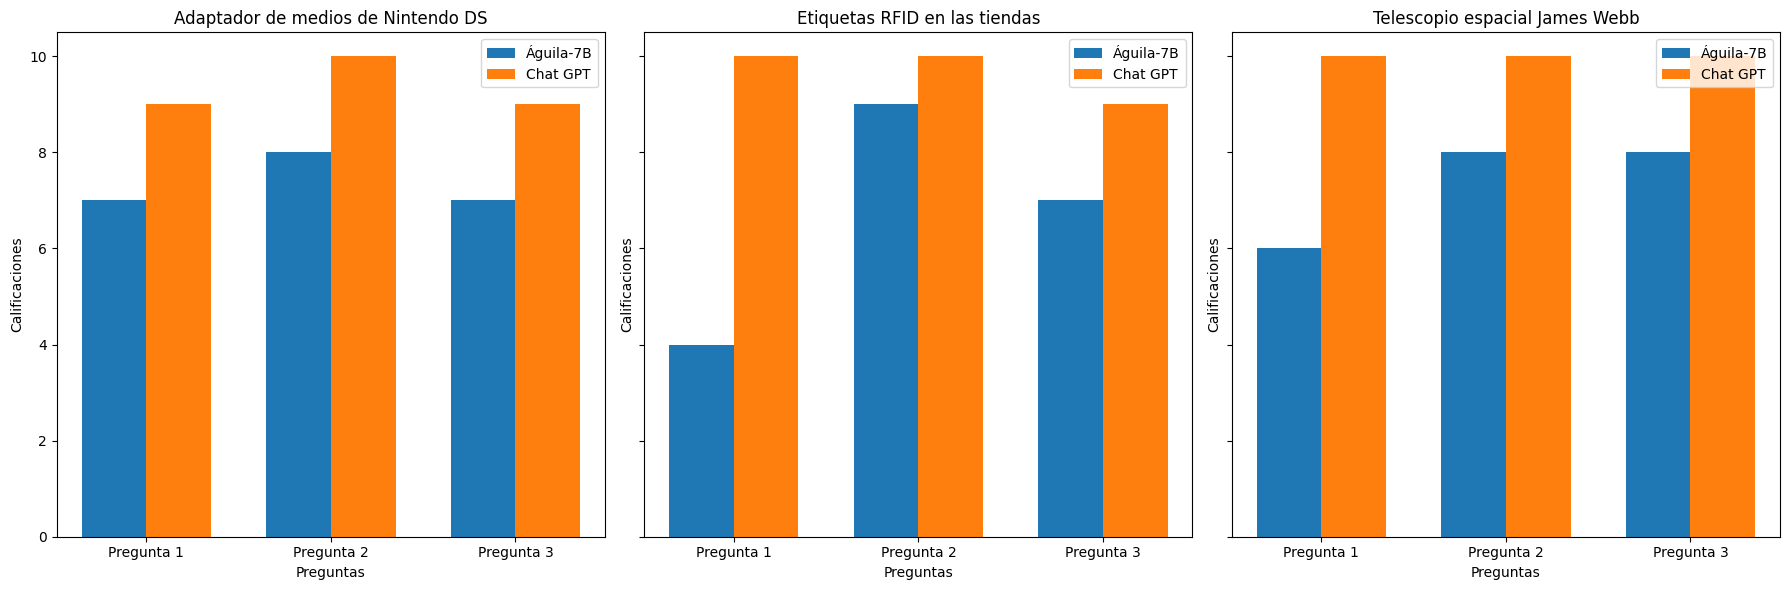

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calificaciones para cada pregunta en cada tema (0 a 10)
# Formato: [Pregunta1, Pregunta2, Pregunta3]
aguila_7b_scores = {
    'Adaptador de medios de Nintendo DS': [7, 8, 7],
    'Etiquetas RFID en las tiendas': [4, 9, 7],
    'Telescopio espacial James Webb': [6, 8, 8]
}

chatgpt_scores = {
    'Adaptador de medios de Nintendo DS': [9, 10, 9],
    'Etiquetas RFID en las tiendas': [10, 10, 9],
    'Telescopio espacial James Webb': [10, 10, 10]
}

# Definir las etiquetas de los temas y las preguntas
temas = list(aguila_7b_scores.keys())
preguntas = ['Pregunta 1', 'Pregunta 2', 'Pregunta 3']

# Crear una figura con subgráficos
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, tema in enumerate(temas):
    # Datos para las barras
    x = np.arange(len(preguntas))
    width = 0.35

    # Crear las barras para Águila-7B y Chat GPT
    axs[i].bar(x - width/2, aguila_7b_scores[tema], width, label='Águila-7B')
    axs[i].bar(x + width/2, chatgpt_scores[tema], width, label='Chat GPT')

    # Etiquetas y títulos
    axs[i].set_xlabel('Preguntas')
    axs[i].set_ylabel('Calificaciones')
    axs[i].set_title(tema)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(preguntas)
    axs[i].legend()

# Ajustar el diseño y mostrar los gráficos
fig.tight_layout()
plt.show()


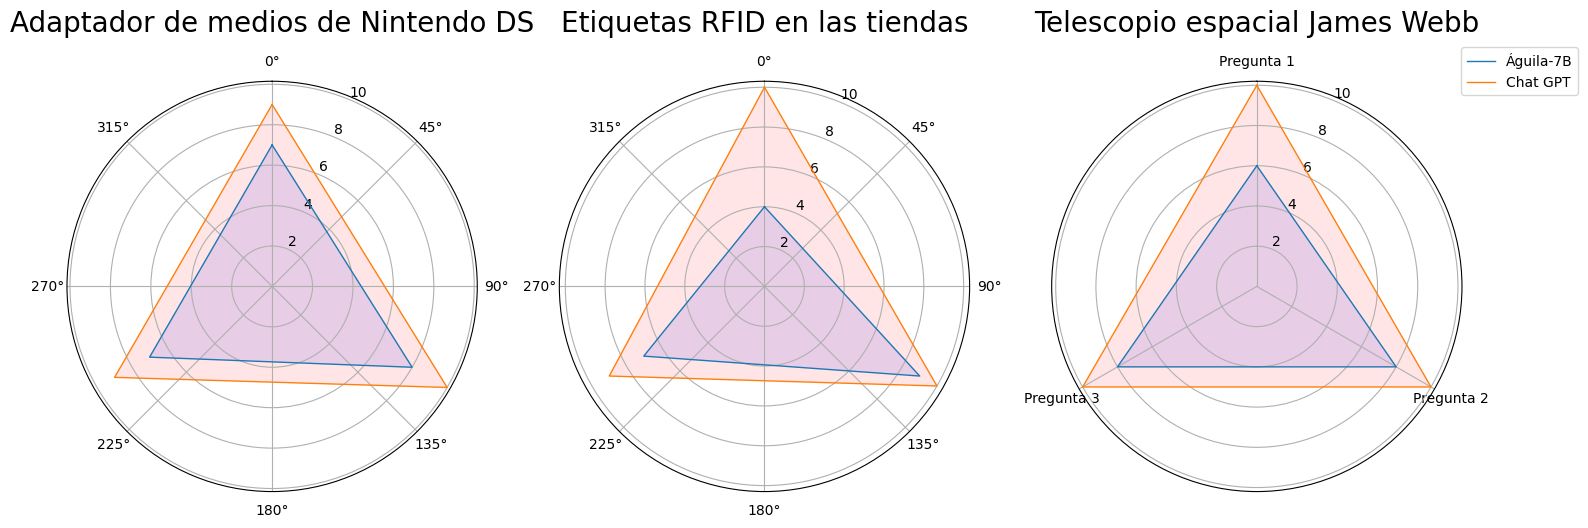

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calificaciones para cada pregunta en cada tema (0 a 10)
# Formato: [Pregunta1, Pregunta2, Pregunta3]
aguila_7b_scores = {
    'Adaptador de medios de Nintendo DS': [7, 8, 7],
    'Etiquetas RFID en las tiendas': [4, 9, 7],
    'Telescopio espacial James Webb': [6, 8, 8]
}

chatgpt_scores = {
    'Adaptador de medios de Nintendo DS': [9, 10, 9],
    'Etiquetas RFID en las tiendas': [10, 10, 9],
    'Telescopio espacial James Webb': [10, 10, 10]
}

# Función para crear gráficos de radar
def create_radar_chart(labels, scores1, scores2, title, ax):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    scores1 += scores1[:1]
    scores2 += scores2[:1]
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], labels)

    ax.plot(angles, scores1, linewidth=1, linestyle='solid', label='Águila-7B')
    ax.fill(angles, scores1, 'b', alpha=0.1)

    ax.plot(angles, scores2, linewidth=1, linestyle='solid', label='Chat GPT')
    ax.fill(angles, scores2, 'r', alpha=0.1)

    ax.set_title(title, size=20, color='black', y=1.1)
    ax.grid(True)

# Crear la figura
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(polar=True))

temas = list(aguila_7b_scores.keys())
preguntas = ['Pregunta 1', 'Pregunta 2', 'Pregunta 3']

for i, tema in enumerate(temas):
    create_radar_chart(preguntas, aguila_7b_scores[tema], chatgpt_scores[tema], tema, axs[i])

# Añadir leyenda
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


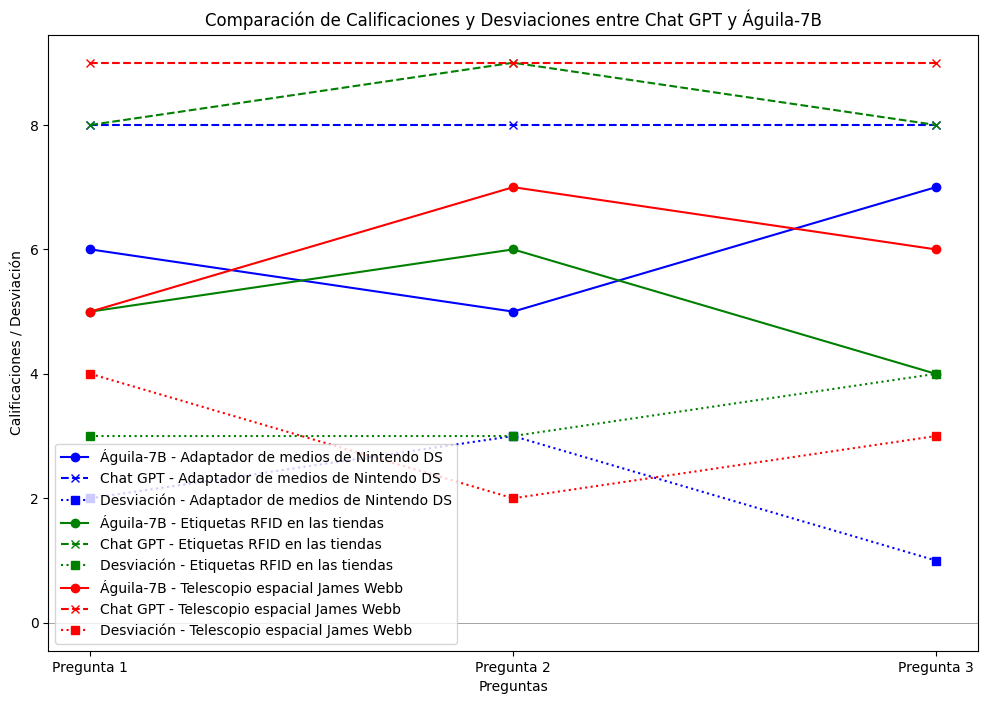

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calificaciones para cada pregunta en cada tema (0 a 10)
aguila_7b_scores = {
    'Adaptador de medios de Nintendo DS': [6, 5, 7],
    'Etiquetas RFID en las tiendas': [5, 6, 4],
    'Telescopio espacial James Webb': [5, 7, 6]
}

chatgpt_scores = {
    'Adaptador de medios de Nintendo DS': [8, 8, 8],
    'Etiquetas RFID en las tiendas': [8, 9, 8],
    'Telescopio espacial James Webb': [9, 9, 9]
}

# Calcular la desviación o el error entre las calificaciones
deviations = {
    tema: np.array(chatgpt_scores[tema]) - np.array(aguila_7b_scores[tema])
    for tema in aguila_7b_scores
}

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Colores para cada tema
colors = ['blue', 'green', 'red']

# Trazar las calificaciones y las desviaciones para cada tema
for idx, (tema, deviation) in enumerate(deviations.items()):
    # Plot Aguila-7B scores
    ax.plot(['Pregunta 1', 'Pregunta 2', 'Pregunta 3'], aguila_7b_scores[tema], marker='o', color=colors[idx], linestyle='-', label=f'Águila-7B - {tema}')
    # Plot Chat GPT scores
    ax.plot(['Pregunta 1', 'Pregunta 2', 'Pregunta 3'], chatgpt_scores[tema], marker='x', color=colors[idx], linestyle='--', label=f'Chat GPT - {tema}')
    # Plot deviations
    ax.plot(['Pregunta 1', 'Pregunta 2', 'Pregunta 3'], deviation, marker='s', color=colors[idx], linestyle=':', label=f'Desviación - {tema}')

# Añadir etiquetas y título
ax.set_xlabel('Preguntas')
ax.set_ylabel('Calificaciones / Desviación')
ax.set_title('Comparación de Calificaciones y Desviaciones entre Chat GPT y Águila-7B')
ax.axhline(0, color='gray', linewidth=0.5)
ax.legend()

# Mostrar el gráfico
plt.show()

